<a href="https://colab.research.google.com/github/ageltser1/Jarvis/blob/main/Jarvis3_(Upsampled).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File successfully downloaded as OXY_Signals3.csv

=== XGBoost Evaluation ===
Accuracy: 0.8044619422572179
Confusion Matrix:
 [[540  49  57]
 [ 14  35   8]
 [ 11  10  38]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.84      0.89       646
         1.0       0.37      0.61      0.46        57
         2.0       0.37      0.64      0.47        59

    accuracy                           0.80       762
   macro avg       0.57      0.70      0.61       762
weighted avg       0.87      0.80      0.83       762



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5652 - loss: 0.9448 - val_accuracy: 0.7533 - val_loss: 0.5854
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7444 - loss: 0.6375 - val_accuracy: 0.7598 - val_loss: 0.5248
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7703 - loss: 0.5816 - val_accuracy: 0.7769 - val_loss: 0.4980
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7809 - loss: 0.5705 - val_accuracy: 0.7808 - val_loss: 0.4766
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7880 - loss: 0.5370 - val_accuracy: 0.7835 - val_loss: 0.4837
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8024 - loss: 0.5259 - val_accuracy: 0.7769 - val_loss: 0.4938
Epoch 7/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7933 - loss: 0.5188 - val_accuracy: 0.7861 - val_loss: 0.4802
Epoch 8/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8057 - loss: 0.4980 - val_accuracy: 0.


Training Accuracy = 0.91
Training Loss     = 0.26
Test Accuracy     = 0.82
Test Loss         = 0.44


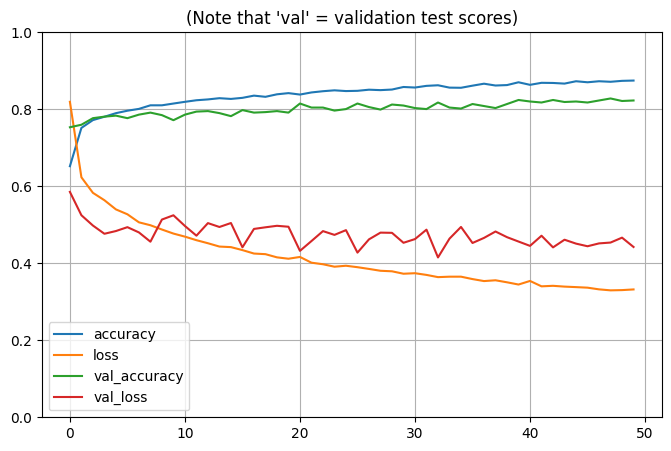

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix for y_pred below: 
[[537  63  46]
 [ 10  42   5]
 [  5   6  48]]
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.90       646
         1.0       0.38      0.74      0.50        57
         2.0       0.48      0.81      0.61        59

    accuracy                           0.82       762
   macro avg       0.61      0.79      0.67       762
weighted avg       0.89      0.82      0.84       762



In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import xgboost as xgb
import random
import requests

# Function to download file
def download_file(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"File successfully downloaded as {filename}")
    else:
        print("Failed to retrieve the file. Status code:", response.status_code)

# Read the input data
url = 'https://raw.githubusercontent.com/ageltser1/Jarvis/refs/heads/main/OXY_Signals3.csv'
filename = "OXY_Signals3.csv"
download_file(url, filename)

df = pd.read_csv(filename, dtype='float64', header=0)
input_data = df.to_numpy()

training_size = int(len(input_data) * 0.8)
train_data = input_data[:training_size]
test_data = input_data[training_size:]

nFeatures = 7
ground_truth_col = 7

train_X = train_data[:, :nFeatures]
train_truth = train_data[:, ground_truth_col]

# === UPSAMPLING ===
train_combined = np.hstack((train_X, train_truth.reshape(-1, 1)))
df_train_combined = pd.DataFrame(train_combined)

majority = df_train_combined[df_train_combined.iloc[:, -1] == 0]
minority1 = df_train_combined[df_train_combined.iloc[:, -1] == 1]
minority2 = df_train_combined[df_train_combined.iloc[:, -1] == 2]

minority1_upsampled = resample(minority1, replace=True, n_samples=len(majority), random_state=42)
minority2_upsampled = resample(minority2, replace=True, n_samples=len(majority), random_state=42)

df_train_balanced = pd.concat([majority, minority1_upsampled, minority2_upsampled])
df_train_balanced = df_train_balanced.sample(frac=1).reset_index(drop=True)

train_X = df_train_balanced.iloc[:, :-1].to_numpy()
train_truth = df_train_balanced.iloc[:, -1].to_numpy()

# Scale data
scaler_obj = preprocessing.StandardScaler().fit(train_X)
train_X_std = scaler_obj.transform(train_X)
test_X_std = scaler_obj.transform(test_data[:, :nFeatures])
test_truth = test_data[:, ground_truth_col]

# === XGBoost ===
dtrain = xgb.DMatrix(train_X_std, label=train_truth)
dtest = xgb.DMatrix(test_X_std, label=test_truth)

params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 5,
    'seed': 42
}

xgb_model = xgb.train(params, dtrain, num_boost_round=100)
xgb_model.save_model("xgb_model_OXY.json")  # Save model

xgb_preds = xgb_model.predict(dtest)

print("\n=== XGBoost Evaluation ===")
print("Accuracy:", accuracy_score(test_truth, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(test_truth, xgb_preds))
print("\nClassification Report:\n", classification_report(test_truth, xgb_preds))

# === Keras Neural Network ===
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(train_X_std.shape[1],), activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_X_std, train_truth,
    batch_size=16,
    epochs=50,
    validation_data=(test_X_std, test_truth),
    verbose=1
)

model.save("keras_model_OXY.h5")  # Save weights

train_loss, train_accuracy = model.evaluate(train_X_std, train_truth, verbose=0)
test_loss, test_accuracy = model.evaluate(test_X_std, test_truth, verbose=0)
print("\nTraining Accuracy = {:.2f}".format(train_accuracy))
print("Training Loss     = {:.2f}".format(train_loss))
print("Test Accuracy     = {:.2f}".format(test_accuracy))
print("Test Loss         = {:.2f}".format(test_loss))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("(Note that 'val' = validation test scores)")
plt.show()

y_pred = model.predict(test_X_std)
y_pred_labels = np.argmax(y_pred, axis=1)
print("Confusion Matrix for y_pred below: ")
print(confusion_matrix(test_truth, y_pred_labels))
print(classification_report(test_truth, y_pred_labels))




In [ ]:
# OPTIONAL: View predictions alongside original data
print('\n  OXY_Close_PD   OXY_Volume     VIX_Close    OXY_PD_AVGs   True_Label  XGB_Prediction')
for i in range(min(70, len(test_X_std))):
    print('  {:4.0e}           {:4.0e}          {:3.0e}         {:3.0e}         {}         {}'.format(
        test_X_std[i, 0], test_X_std[i, 1], test_X_std[i, 2], test_X_std[i, 3],
        int(test_truth[i]), int(xgb_preds[i])
    ))



  OXY_Close_PD   OXY_Volume     VIX_Close    OXY_PD_AVGs   True_Label  XGB_Prediction
  3e-01           9e-02          4e-01         9e-01         1         1
  3e-01           4e-01          -2e-01         1e+00         1         1
  2e-01           -5e-01          -7e-01         8e-01         0         1
  3e-01           9e-01          -8e-01         1e+00         0         0
  3e-01           -2e-01          -7e-01         1e+00         0         0
  2e-01           -1e+00          -5e-01         4e-01         0         0
  2e-01           2e-01          -5e-01         5e-01         0         0
  3e-01           1e+00          -1e-01         8e-01         2         1
  6e-01           3e+00          2e-01         2e+00         2         2
  3e-01           -2e+00          3e-01         5e-01         0         1
  4e-01           8e-01          7e-01         8e-01         0         0
  4e-01           3e-01          1e+00         9e-01         0         0
  4e-01           -2e-01  

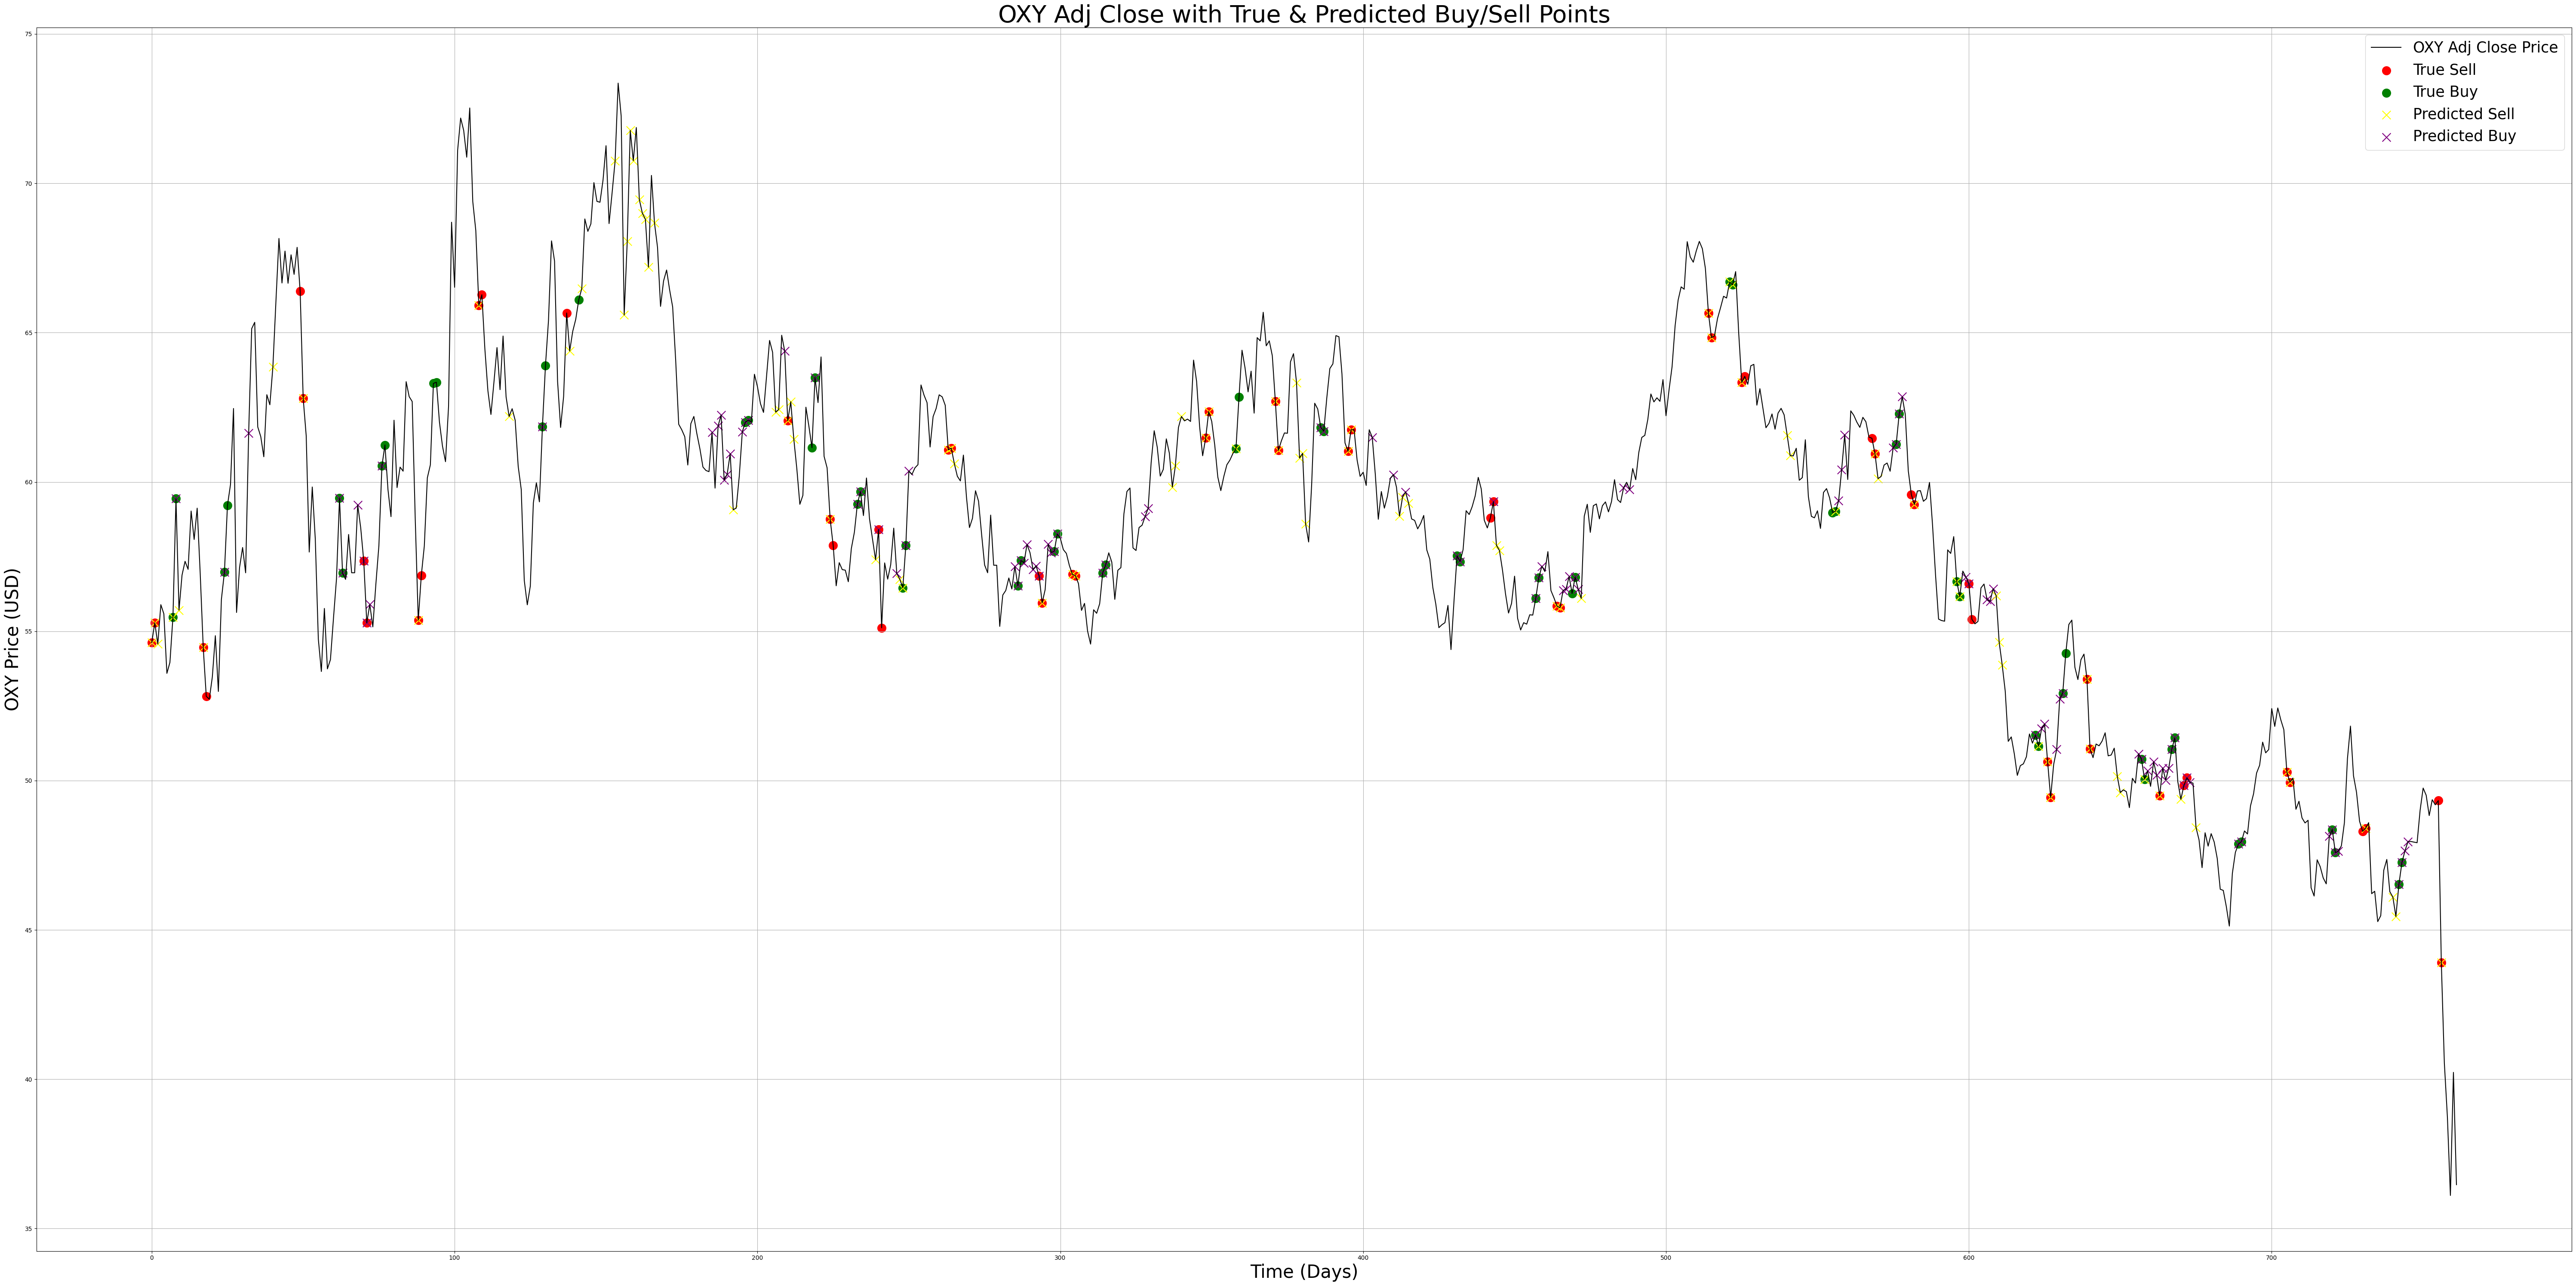

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the prices used in test set
oxy_prices = df['OXY_Close'].values[-len(test_X_std):]

# Create a time axis
time = np.arange(len(test_X_std))

# Create a large figure
plt.figure(figsize=(60, 30))

# Plot main price line
plt.plot(time, oxy_prices, color='black', label='OXY Adj Close Price')

# Track whether we've added labels to avoid duplicates
added_labels = {
    "true_sell": False,
    "true_buy": False,
    "pred_sell": False,
    "pred_buy": False,
}

# Plot True Labels
for i in range(len(test_truth)):
    if test_truth[i] == 1:
        label = 'True Sell' if not added_labels["true_sell"] else ""
        plt.scatter(time[i], oxy_prices[i], color='red', label=label, s=200)
        added_labels["true_sell"] = True
    elif test_truth[i] == 2:
        label = 'True Buy' if not added_labels["true_buy"] else ""
        plt.scatter(time[i], oxy_prices[i], color='green', label=label, s=200)
        added_labels["true_buy"] = True

# Plot XGB Predictions
for i in range(len(xgb_preds)):
    if xgb_preds[i] == 1:
        label = 'Predicted Sell' if not added_labels["pred_sell"] else ""
        plt.scatter(time[i], oxy_prices[i], color='yellow', marker='x', label=label, s=200)
        added_labels["pred_sell"] = True
    elif xgb_preds[i] == 2:
        label = 'Predicted Buy' if not added_labels["pred_buy"] else ""
        plt.scatter(time[i], oxy_prices[i], color='purple', marker='x', label=label, s=200)
        added_labels["pred_buy"] = True

# Titles and legend
plt.title('OXY Adj Close with True & Predicted Buy/Sell Points', fontsize=40)
plt.xlabel('Time (Days)', fontsize=30)
plt.ylabel('OXY Price (USD)', fontsize=30)
plt.legend(loc='best', fontsize=25)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Setup time axis
time = np.arange(len(test_X_std))
oxy_prices = df['OXY_Close'].values[-len(test_X_std):]  # Ensure this slice aligns with test_X

# Create figure
fig = go.Figure()

# Stock price line (black)
fig.add_trace(go.Scatter(
    x=time, y=oxy_prices,
    mode='lines',
    name='OXY Adj Close',
    line=dict(color='black')
))

# True Labels: Sell = Red, Buy = Green
fig.add_trace(go.Scatter(
    x=time[test_truth == 1],
    y=oxy_prices[test_truth == 1],
    mode='markers',
    name='True Sell',
    marker=dict(color='red', size=12, symbol='circle')
))

fig.add_trace(go.Scatter(
    x=time[test_truth == 2],
    y=oxy_prices[test_truth == 2],
    mode='markers',
    name='True Buy',
    marker=dict(color='green', size=12, symbol='circle')
))

# XGB Predictions: Sell = Yellow, Buy = Purple
fig.add_trace(go.Scatter(
    x=time[xgb_preds == 1],
    y=oxy_prices[xgb_preds == 1],
    mode='markers',
    name='Predicted Sell',
    marker=dict(color='yellow', size=12, symbol='x')
))

fig.add_trace(go.Scatter(
    x=time[xgb_preds == 2],
    y=oxy_prices[xgb_preds == 2],
    mode='markers',
    name='Predicted Buy',
    marker=dict(color='purple', size=12, symbol='x')
))

# Larger layout and styling
fig.update_layout(
    title='Interactive OXY Price with True and Predicted Buy/Sell Signals',
    xaxis_title='Time (Days)',
    yaxis_title='Adjusted Close Price (USD)',
    legend=dict(font=dict(size=16)),
    height=1200,   # Increased height
    width=3000,    # Increased width
    template='plotly_white',
    font=dict(size=18)
)

fig.show()


### Running Simulation with initial portfolio value of $1000 and following predicted actions on Test Data.

In [ ]:
initial_cash = 1000.0
portfolio_value = initial_cash
shares_held = 0
position_open = False
transactions = []

previous_portfolio_value = initial_cash  # Tracks last transaction value

# We assume xgb_preds aligns with the test data portion of df
predictions_start_idx = len(df) - len(xgb_preds)

for i, pred in enumerate(xgb_preds):
    idx = predictions_start_idx + i
    price = df['OXY_Close'].iloc[idx]

    if pred == 2 and not position_open:  # Buy
        shares_held = portfolio_value / price
        print(f"\nBUY: Day {idx}, Price: ${price:.2f}, Shares Purchased: {shares_held:.4f}")
        print(f"Portfolio Value After Purchase: ${portfolio_value:.2f}")
        transactions.append({
            'type': 'buy',
            'price': price,
            'shares': shares_held,
            'portfolio_value': portfolio_value,
            'index': idx
        })
        previous_portfolio_value = portfolio_value  # Save portfolio value for later gain/loss
        portfolio_value = 0
        position_open = True

    elif pred == 1 and position_open:  # Sell
        cash_from_sale = shares_held * price
        gain_loss = cash_from_sale - previous_portfolio_value
        percent_change = (gain_loss / previous_portfolio_value) * 100
        portfolio_value = cash_from_sale
        print(f"\nSELL: Day {idx}, Price: ${price:.2f}, Shares Sold: {shares_held:.4f}")
        print(f"Gain/Loss from trade: ${gain_loss:.2f} ({percent_change:.2f}%)")
        print(f"Portfolio Value After Sale: ${portfolio_value:.2f}")
        transactions.append({
            'type': 'sell',
            'price': price,
            'shares': shares_held,
            'cash_from_sale': cash_from_sale,
            'gain_loss': gain_loss,
            'percent_change': percent_change,
            'portfolio_value': portfolio_value,
            'index': idx
        })
        previous_portfolio_value = portfolio_value
        shares_held = 0
        position_open = False

# Final forced sell if still holding
if position_open:
    final_price = df['OXY_Close'].iloc[-1]
    cash_from_sale = shares_held * final_price
    gain_loss = cash_from_sale - previous_portfolio_value
    percent_change = (gain_loss / previous_portfolio_value) * 100
    portfolio_value = cash_from_sale
    print(f"\nFINAL SELL: Day {len(df)-1}, Price: ${final_price:.2f}, Shares Sold: {shares_held:.4f}")
    print(f"Gain/Loss from trade: ${gain_loss:.2f} ({percent_change:.2f}%)")
    print(f"Final Portfolio Value: ${portfolio_value:.2f}")
    transactions.append({
        'type': 'sell',
        'price': final_price,
        'shares': shares_held,
        'cash_from_sale': cash_from_sale,
        'gain_loss': gain_loss,
        'percent_change': percent_change,
        'portfolio_value': portfolio_value,
        'index': len(df) - 1
    })

# Final summary
total_gain_loss = portfolio_value - initial_cash
print("\n=== FINAL REPORT ===")
print(f"Final Portfolio Value: ${portfolio_value:.2f}")
print(f"Total Gain/Loss: ${total_gain_loss:.2f}")



BUY: Day 3055, Price: $59.44, Shares Purchased: 16.8238
Portfolio Value After Purchase: $1000.00

SELL: Day 3056, Price: $55.71, Shares Sold: 16.8238
Gain/Loss from trade: $-62.78 (-6.28%)
Portfolio Value After Sale: $937.22

BUY: Day 3071, Price: $56.98, Shares Purchased: 16.4489
Portfolio Value After Purchase: $937.22

SELL: Day 3087, Price: $63.85, Shares Sold: 16.4489
Gain/Loss from trade: $113.12 (12.07%)
Portfolio Value After Sale: $1050.33

BUY: Day 3109, Price: $59.47, Shares Purchased: 17.6631
Portfolio Value After Purchase: $1050.33

SELL: Day 3135, Price: $55.37, Shares Sold: 17.6631
Gain/Loss from trade: $-72.34 (-6.89%)
Portfolio Value After Sale: $978.00

BUY: Day 3176, Price: $61.85, Shares Purchased: 15.8114
Portfolio Value After Purchase: $978.00

SELL: Day 3185, Price: $64.38, Shares Sold: 15.8114
Gain/Loss from trade: $40.00 (4.09%)
Portfolio Value After Sale: $1018.00

BUY: Day 3232, Price: $61.66, Shares Purchased: 16.5095
Portfolio Value After Purchase: $1018.00


Add ^^ Make a plot to show individual buys and sell decisions (first of each kind) as coded for above